In [1]:
# Load all packages
from os.path import join
import mat73
import matplotlib.pyplot as plt
import numpy as np
import mne
# For moving average... not sure if good
from scipy.ndimage import uniform_filter1d

In [2]:
# Load data into dictionary
DataPath = join("neuro_data","dataSubj10.mat")
data_dict = mat73.loadmat(DataPath, use_attrdict=True)
data = data_dict["data"]

In [3]:
# Function to transform data to appropriate shape

def DimConvertFunc(trial, all_channels, bad_channels, n_samples):
    """Converts 60 channel data to 74 channel data with dummy info, in order to fit EasyCap format.

    Args:
        trial (array of floats): data from channel
        moving_window (int, optional): moving average window to smoothen data for visualization. Defaults to 0.

    Returns:
        _type_: _description_
    """
    newTrial = np.zeros((len(all_channels),n_samples))
    j = 0
    filler = [0]*n_samples
    for i, ch in enumerate(all_channels):
        if ch in bad_channels:
            newTrial[i]=filler
        else:
            newTrial[i]=trial[j]
            j += 1
    return newTrial

In [4]:
# Constants
sfreq = data["fsample"] # Sampling frequency
used_channels = [ch[0].upper() for ch in data["label"]]
all_channels = [ch[0] for ch in data["elec"]["label"]] # Not all upper case
used_channel_case = [ch for ch in all_channels if ch.upper() in used_channels] # match cases
bad_channels = list(set(all_channels).difference(set(used_channel_case))) # Channels not used
n_samples = len(data["trial"][0][0]) # Amount of measurements for each channel in a trial

# MNE data structures

info = mne.create_info(all_channels, sfreq, "eeg")
info.set_montage('easycap-M1')
info["bads"] = bad_channels

# Dict with trial info
n = len(data["trialinfo"])
metadata = [0]*n
for i, trialinfo in enumerate(data["trialinfo"]):
    # side : left = 1, right = 2
    # side_accuracy : Correct (1) Incorrect (2) No response (3) Almost correct (4)
    metadata[i] = {"side":int(trialinfo[0]["side"]),"accurate":int(trialinfo[0]["side_accuracy"])}

event_label = [event["side"] for event in metadata] # actual info, must be converted to shape (N,3)
events = np.zeros((n,3))
events[:,2] = np.array(event_label)  #Add labels to 3rd column, 2nd column irrelevant, but shape needed
events[:,0] = np.array(range(n))     #Add dummy IDs to first column
events = events.astype(int)

event_dict = {"auditory/left":1, "auditory/right":2}

# Create array with 74 instead of 60 channel data to fit Easycap Scheme
rawdata_UpScaledDim = np.array([DimConvertFunc(epoch, all_channels, bad_channels, n_samples) for epoch in data["trial"]])
epochs = mne.EpochsArray(rawdata_UpScaledDim, info, tmin=-2, events=events, event_id=event_dict, baseline=(-2,0))

Not setting metadata
352 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


# Sensor Visualizations

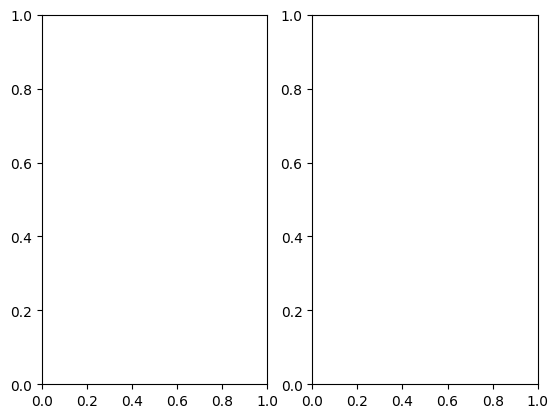

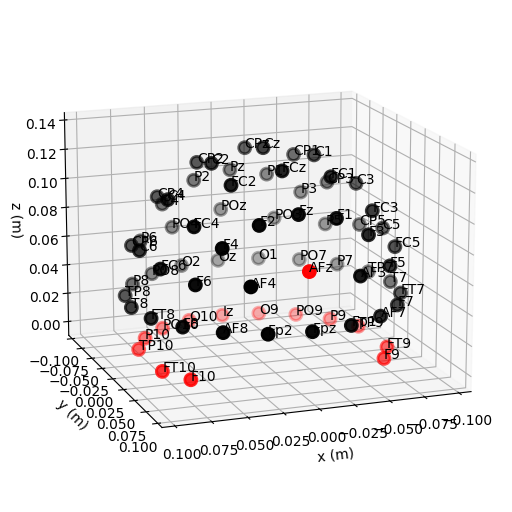

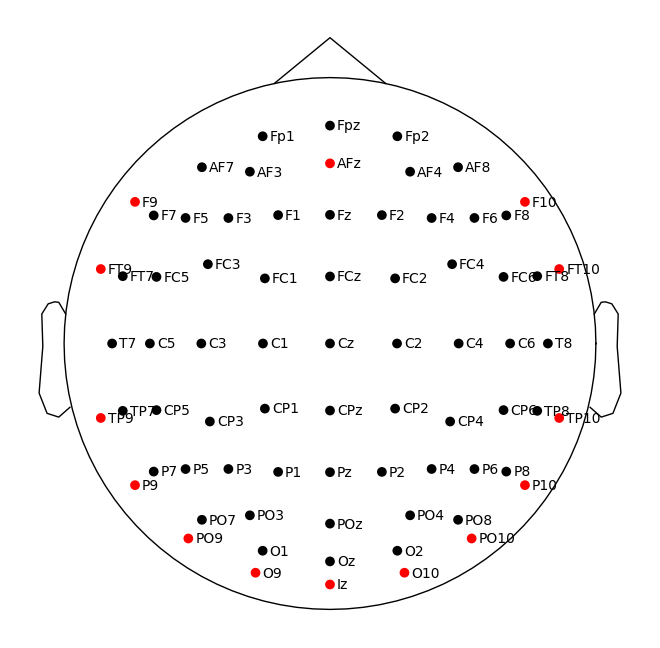

In [5]:
fig, ax = plt.subplots(1,2)
ax[0] = epochs.plot_sensors(kind="3d", ch_type="all", show_names=True, show=False)
ax[0].gca().view_init(azim=70, elev=15)
ax[1] = epochs.plot_sensors(kind="topomap", ch_type="all", show_names=True)

# Demo Time-Frequency Representation

Applying baseline correction (mode: logratio)


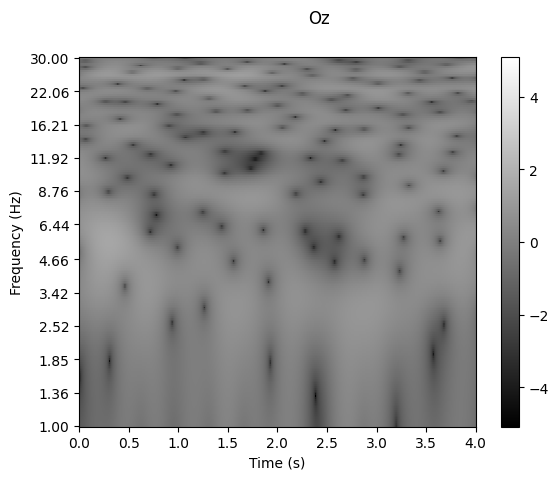

In [96]:
freqs = np.logspace(*np.log10([1,30]), num=200) # Frequencies of interest for spectrogram
n_cycles = freqs / 1.  # Why this choice?
power = mne.time_frequency.tfr_morlet(epochs[0], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False)

power.plot(['Oz'], baseline=(-2,0), mode="logratio", title='Oz', tmin=0, tmax=4, cmap="binary_r")
# Save only image part 
# https://stackoverflow.com/questions/8218608/scipy-savefig-without-frames-axes-only-content


fig.savefig("test.png", bbox_inches='tight')

# Prepare images for ML

Save pure TFR images, with some compression.

In [128]:
def GenerateTFR(epoch, channels, freqs, n_cycles, savepath, decim=3):
    """Generates Time-Frequency representation for given channels of EEG data

    Args:
        epoch (_type_): The sample for which to create spectrograms
        channels (_type_): List of channels names for which spectrograms are desired
        freqs (_type_): Array of desired frequencies
        n_cycles (_type_): ???
        savepath (_type_): Path to folder where images will be saved
        decim (int, optional): Down-sampling factor to speed up calculation. Defaults to 3.
    """
    power = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=decim)
    for ch in channels:
        fig, ax = plt.subplots(1,1)
        plt.axis('off')
        power.plot([ch], baseline=(-2,0), mode="logratio", tmin=0, tmax=4, cmap="binary_r", axes=ax, colorbar=False, show=False, verbose=False)
        fig.savefig(savepath+ch+".png",bbox_inches='tight',pad_inches=0)
        plt.close()

In [130]:
from tqdm import tqdm # For progress bar

freqs = np.logspace(*np.log10([1,30]), num=10) # Frequencies of interest for spectrogram
n_cycles = freqs / 1.  # Why this choice?
savepath = "TFR_Plots/"
for i in tqdm(range(len(epochs))):
    GenerateTFR(epochs[i],["Oz","Fpz"], freqs, n_cycles, savepath+str(i)+"_")

100%|██████████| 352/352 [02:42<00:00,  2.17it/s]
